# Grid snapping

GDS represents points as integers where each point corresponds to a database unit (DBU). Typically, in most foundries, the default DBU is set to 1 nanometer (1nm).

gdsfactory snaps ports to the grid by default to avoid grid snapping errors which are common in layout designs.


![](https://i.imgur.com/SUXBWed.png)

Example of grid snapping errors.

![](https://i.imgur.com/suiHyqM.png)



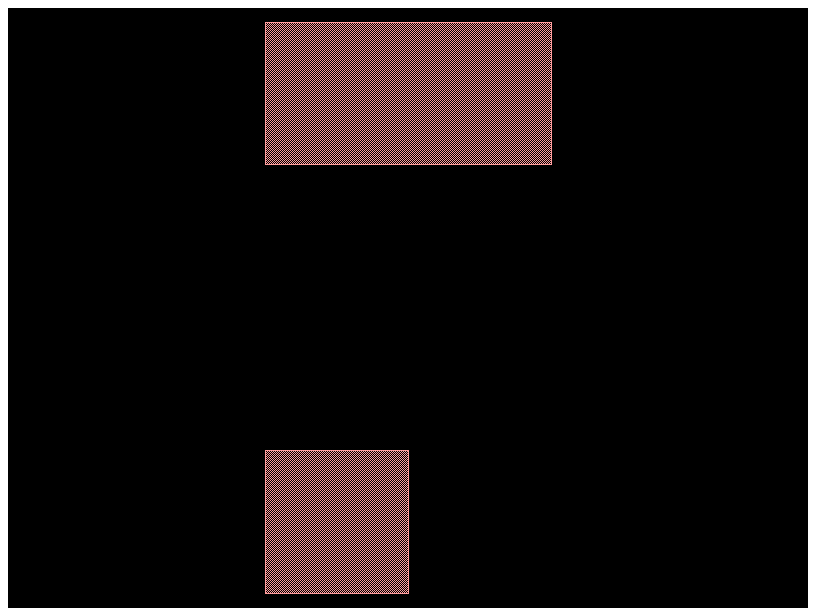

2025-03-27 15:13:03.208 | INFO     | kfactory.kcell:show:3385 - klive v0.3.3: Opened file '/home/nynra/repos/pytools-lithography/pytools-litho-design/build/gds/4020511028.oas'


In [ ]:
import gdsfactory as gf

nm = 1e-3

wg1 = gf.Component()
wg1.add_polygon(
    [(0, 0), (1.4 * nm, 0), (1.4 * nm, 1 * nm), (0, 1 * nm)], layer=(1, 0)
)  # rounds to 1 nm

wg1.add_polygon(
    [(0, 3 * nm), (1.6 * nm, 3 * nm), (1.6 * nm, 4 * nm), (0, 4 * nm)], layer=(1, 0)
)  # rounds to 2 nm

wg1.plot()

## ⚠️ Warning: Manhattan Orientations
It's crucial to always maintain ports with Manhattan orientations (0, 90, 180, 270 degrees). Non-Manhattan ports can lead to ports snapping off the grid, resulting in 1nm gaps in your layouts, which can be detrimental to the design's integrity.

Although **gdsfactory** provides functions to connect and route component ports that are off-grid or have non-Manhattan orientations, this feature is **disabled by default** for safety reasons.

> **Note:** If you intend to create off-grid ports and non-Manhattan connections, you must enable this feature manually. This should be done with caution and a thorough understanding of the potential implications on your design.

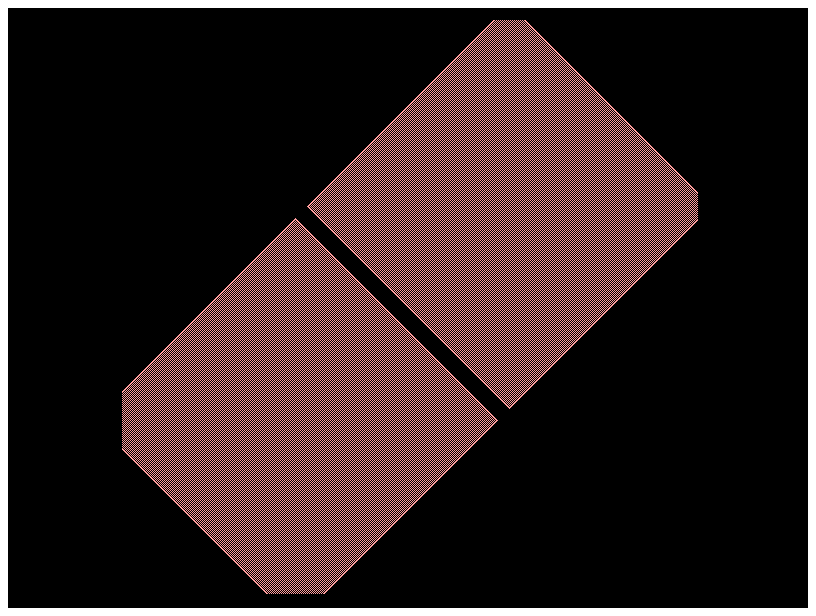

In [2]:
c = gf.Component()
w1 = c << gf.c.straight(length=4 * nm, width=4 * nm)
w1.drotate(45)

w2 = c << gf.c.straight(length=4 * nm, width=4 * nm)
w2.connect("o1", w1["o2"])
c  # in this case ports overlap by an extra nm because of the rotation, instead of connecting them with no overlap

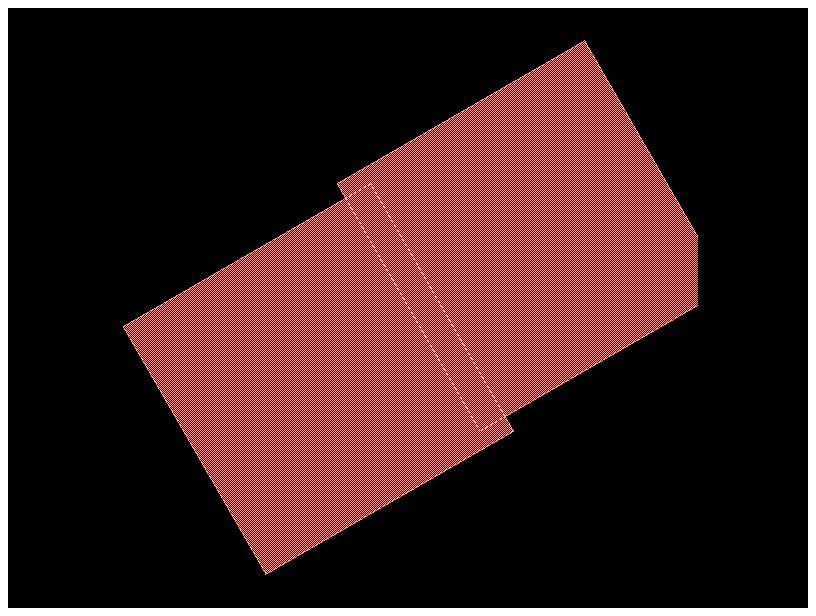

In [3]:
c = gf.Component()
w1 = c << gf.components.straight(length=4 * nm, width=4 * nm)
w1.drotate(30)

w2 = c << gf.components.straight(length=4 * nm, width=4 * nm)
w2.connect("o1", w1["o2"])
c  # in this case ports have a 1nm gap error because of the rotation


## Fix Non manhattan connections

The GDS format often has issues with non-manhattan shapes, due to the rounding of vertices to a unit grid and to downstream tools (i.e. DRC) which often tend to assume cell references only have rotations at 90 degree intervals.

To fix it, you can insert them as virtual instances.

For example:

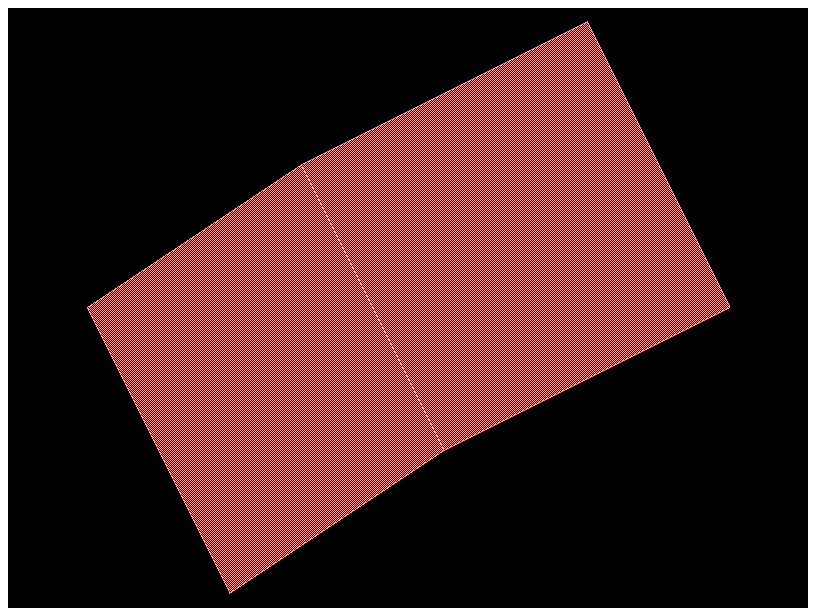

In [4]:
import gdsfactory as gf

nm = 1e-3
c = gf.Component()
w = gf.components.straight(length=4 * nm, width=4 * nm)
w1 = c.create_vinst(w)
w1.rotate(30)

w2 = c.create_vinst(w)
w2.connect("o1", w1["o2"])
c

/home/nynra/repos/pytools-lithography/pytools-litho-design/venv/lib/python3.12/site-packages/kfactory/layout.py:704: UserWarning: bend_euler angle should be 90 or 180. Got 30. Use bend_euler_all_angle instead.
  cell = f(**params)  # type: ignore[call-arg]


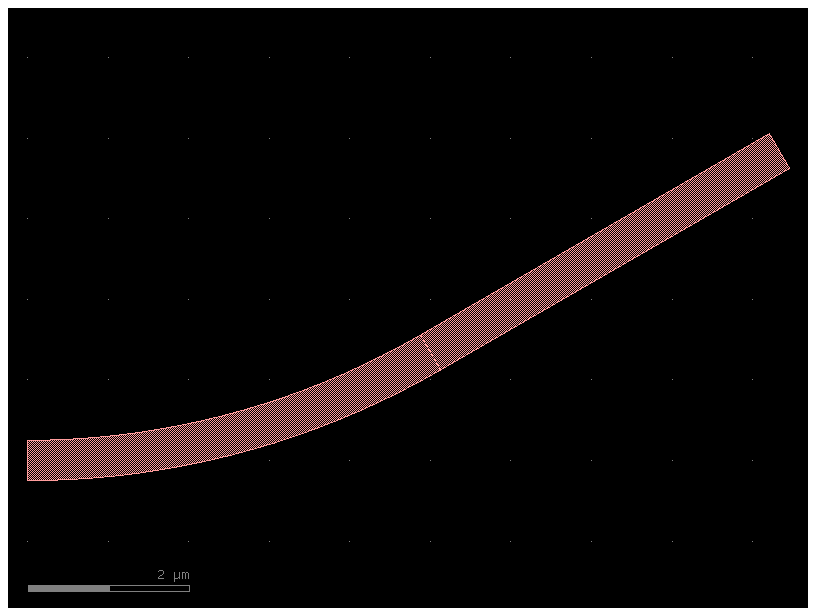

In [5]:
import gdsfactory as gf


@gf.cell(check_instances="none")
def demo_non_manhattan():
    c = gf.Component("bend")
    b = c << gf.components.bend_circular(angle=30)
    s = c << gf.components.straight(length=5)
    s.connect("o1", b.ports["o2"])
    return c


c1 = demo_non_manhattan()
c1

if you zoom in between the bends you will see a notch between waveguides due to non-manhattan connection between the bends.

![gap](https://i.imgur.com/jBEwy9T.png)


## Solution

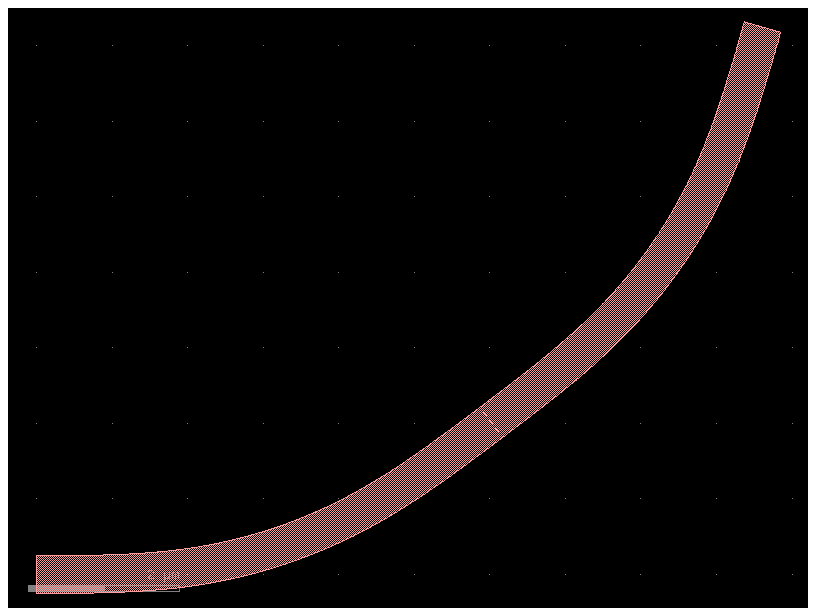

In [6]:
import gdsfactory as gf


@gf.vcell
def snap_bends() -> gf.ComponentAllAngle:
    c = gf.ComponentAllAngle()
    b = gf.c.bend_euler_all_angle(angle=37)
    b1 = c << b
    b2 = c << b
    b2.connect("o1", b1.ports["o2"])
    c.add_port("o1", port=b1.ports["o1"])
    c.add_port("o2", port=b2.ports["o2"])
    return c


c = snap_bends()
c

In [7]:
c.show()

If you zoom in the connection you will see now a perfect connection.

![no gap](https://i.imgur.com/VbSgIjP.png)